Predicting the popularity of a product.
Least popular can be discontinued

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from glob import glob
sns.set()
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score
from sklearn import set_config
set_config(display = "diagram")  

In [3]:
#set the file directory
os.chdir('C:/Users/vetri/OneDrive/Documents/UArizonaEller/Coursework/Fall 2023/MIS545/Project/SalesData')

In [4]:
#read the dataset to dataframe
amazonSaleRepDF = pd.read_excel('Amazon Sale Report.xlsx',sheet_name='Amazon')

In [5]:
#Display summary statistics
amazonSaleRepDF.describe()

,Date,Qty,Amount,ship-postal-code,Unnamed: 22
count,128975,128975.000000,121180.000000,128942.000000,79925.0
mean,2022-05-12 11:49:27.951928576,0.904431,648.561465,463966.236509,0.0
min,2022-03-31 00:00:00,0.000000,0.000000,110001.000000,0.0
25%,2022-04-20 00:00:00,1.000000,449.000000,382421.000000,0.0
50%,2022-05-10 00:00:00,1.000000,605.000000,500033.000000,0.0
75%,2022-06-04 00:00:00,1.000000,788.000000,600024.000000,0.0
max,2022-06-29 00:00:00,15.000000,5584.000000,989898.000000,0.0
std,NaN,0.313354,281.211687,191476.764941,0.0


In [6]:
#Display the structure of the dataset
amazonSaleRepDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order ID            128975 non-null  object        
 1   Date                128975 non-null  datetime64[ns]
 2   Status              128975 non-null  object        
 3   Fulfilment          128975 non-null  object        
 4   Sales Channel       128975 non-null  object        
 5   ship-service-level  128975 non-null  object        
 6   Style               128975 non-null  object        
 7   SKU                 128975 non-null  object        
 8   Category            128975 non-null  object        
 9   Size                128975 non-null  object        
 10  ASIN                128975 non-null  object        
 11  Courier Status      122103 non-null  object        
 12  Qty                 128975 non-null  int64         
 13  currency            121180 no

In [6]:
#print column names as list
amazonSaleRepDF.columns.tolist()

['Order ID',
 'Date',
 'Status',
 'Fulfilment',
 'Sales Channel ',
 'ship-service-level',
 'Style',
 'SKU',
 'Category',
 'Size',
 'ASIN',
 'Courier Status',
 'Qty',
 'currency',
 'Amount',
 'ship-city',
 'ship-state',
 'ship-postal-code',
 'ship-country',
 'promotion-ids',
 'B2B',
 'fulfilled-by',
 'Unnamed: 22']

DATA CLEANING (Exploratory Data Analysis)

In [7]:
#remove spaces and special characters from column names
amazonSaleRepDF.columns = amazonSaleRepDF.columns.str.replace('_', '').str.replace('-','').str.replace(' ','')


In [8]:
#change the column names to lower case
amazonSaleRepDF.columns = map(str.lower, amazonSaleRepDF.columns)
print(amazonSaleRepDF.columns.tolist())

['orderid', 'date', 'status', 'fulfilment', 'saleschannel', 'shipservicelevel', 'style', 'sku', 'category', 'size', 'asin', 'courierstatus', 'qty', 'currency', 'amount', 'shipcity', 'shipstate', 'shippostalcode', 'shipcountry', 'promotionids', 'b2b', 'fulfilledby', 'unnamed:22']


In [9]:
#check for null values
amazonSaleRepDF.isnull().sum()

orderid                 0
date                    0
status                  0
fulfilment              0
saleschannel            0
shipservicelevel        0
style                   0
sku                     0
category                0
size                    0
asin                    0
courierstatus        6872
qty                     0
currency             7795
amount               7795
shipcity               33
shipstate              33
shippostalcode         33
shipcountry            33
promotionids        49153
b2b                     0
fulfilledby         89698
unnamed:22          49050
dtype: int64

Feature Analysis on 'orderid'

In [10]:
#dataframe of repeated orderid & sku and store it in repeatedOrderDF
repeatedOrderDF = amazonSaleRepDF[amazonSaleRepDF.duplicated(['orderid','sku'],keep=False)]

In [12]:
#remove rows with status as cancelled
amazonSaleRepPopularDF = amazonSaleRepDF[amazonSaleRepDF.status != 'Cancelled']

In [13]:
unique_orderid_repeat_count = repeatedOrderDF["orderid"].nunique()

In [14]:
# Aggregate the data to find the number of transactions per product (SKU)
product_transactions = amazonSaleRepPopularDF.groupby('sku')['orderid'].count().sort_values(ascending=False)

In [15]:
#define a threshold for popular products
popularThreshold = product_transactions.median()
popularThreshold

7.0

In [19]:
# Create a binary target variable 'Is_Popular'
amazonSaleRepPopularDF['is_popular'] = amazonSaleRepPopularDF['sku'].apply(lambda x: 1 if product_transactions[x] > popularThreshold else 0)

C:\Users\vetri\AppData\Local\Temp\ipykernel_9880\2072981356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonSaleRepPopularDF['is_popular'] = amazonSaleRepPopularDF['sku'].apply(lambda x: 1 if product_transactions[x] > popularThreshold else 0)


In [20]:
# Encode the 'Style' and 'SKU' columns
label_encoder = LabelEncoder()
amazonSaleRepPopularDF['Style_Code'] = label_encoder.fit_transform(amazonSaleRepPopularDF['style'])
amazonSaleRepPopularDF['SKU_Code'] = label_encoder.fit_transform(amazonSaleRepPopularDF['sku'])

C:\Users\vetri\AppData\Local\Temp\ipykernel_9880\3878735635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonSaleRepPopularDF['Style_Code'] = label_encoder.fit_transform(amazonSaleRepPopularDF['style'])
C:\Users\vetri\AppData\Local\Temp\ipykernel_9880\3878735635.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonSaleRepPopularDF['SKU_Code'] = label_encoder.fit_transform(amazonSaleRepPopularDF['sku'])


In [11]:
# count the total number of rows in the dataset occupied by repeated orders
orderid_repeat_rows_count = len(repeatedOrderDF)

# count the number of rows in the dataset occuppied by nonrepeat_orderids
orderid_nonrepeat_rows = amazonSaleRepDF[amazonSaleRepDF["orderid"].duplicated(keep = False) == False]
orderid_nonrepeat_rows_count = len(orderid_nonrepeat_rows)
 
print(f"1. Number of unique orderid with multiple products per orderid purchased: {unique_orderid_repeat_count}\n"
         f"2. Total number of rows of these orderid(s) with multiple products: {orderid_repeat_rows_count}\n"
          f"3. Number of unique orderid with single product per orderid purchased: {orderid_nonrepeat_rows_count}"
         )

1. Number of unique orderid with multiple products per orderid purchased: 7
2. Total number of rows of these orderid(s) with multiple products: 14
3. Number of unique orderid with single product per orderid purchased: 113532


C:\Users\vetri\AppData\Local\Temp\ipykernel_22036\716234506.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x,y-10,data_label[x],color = "white",
C:\Users\vetri\AppData\Local\Temp\ipykernel_22036\716234506.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x,y+5,("Count:\n"+count_label[x]),color = "Darkgreen",


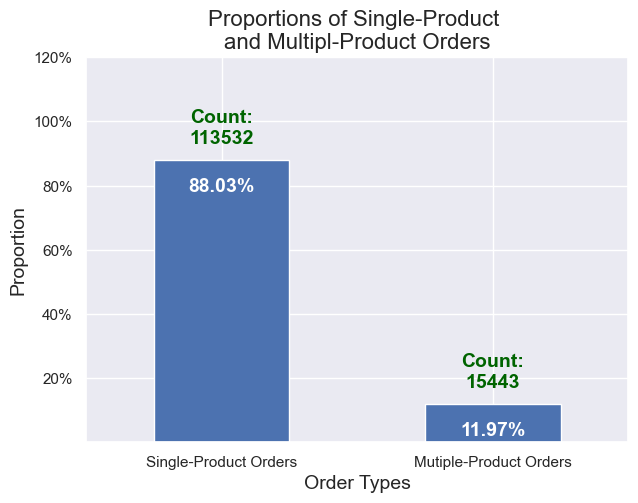

In [12]:
# bar chart using matplotlib package
fig,ax = plt.subplots(figsize = (7,5))

# calculate and store the proportion values in a pandas.Series
orderid_repeat_rows = amazonSaleRepDF[amazonSaleRepDF["orderid"].duplicated(keep = False)]
unique_orderid_repeat_list = orderid_repeat_rows["orderid"].unique()
plot_dataseries = round(amazonSaleRepDF["orderid"].isin(unique_orderid_repeat_list).
                        value_counts(normalize = True)*100,2)

# plot the bar chart
plot_dataseries.plot(kind = "bar",ax =ax)
plt.title("Proportions of Single-Product \nand Multipl-Product Orders", fontsize = 16)
plt.ylabel("Proportion", fontsize = 14)
plt.xlabel("Order Types", fontsize = 14)
plt.xticks(ticks = plot_dataseries.index,
           labels = ["Single-Product Orders", "Mutiple-Product Orders"], rotation = "horizontal")
plt.yticks(ticks = [20,40,60,80,100,120], labels = ["20%","40%","60%","80%","100%","120%"])

# create another two series with values to be diaplayed as data-label/value-label in the chart
data_label = plot_dataseries.astype(str).str.cat(np.full((2,),"%"), sep = "")
count_label = pd.Series(amazonSaleRepDF["orderid"].isin(unique_orderid_repeat_list).value_counts()).astype("str")

# add/plot the data-label in the chart
# in percentage format
for x,y in enumerate(plot_dataseries):
    plt.text(x,y-10,data_label[x],color = "white",
             fontweight = 700,fontsize = 14, horizontalalignment = "center")
    
# in count values format
for x,y in enumerate(plot_dataseries):
    plt.text(x,y+5,("Count:\n"+count_label[x]),color = "Darkgreen",
             fontweight = 700,fontsize = 14, horizontalalignment = "center")
plt.show()


Observations:

We see that 88.03% (almost 90%)of the data are from orders with single-product order.
We are now interested in the majority and, therefore, drop the multiple-product orders.
And, we focus our analysis on the single-product orders for prediction/classification

In [13]:
# drop the orderids with multiple products
amazonSaleRepDF = amazonSaleRepDF[amazonSaleRepDF["orderid"].duplicated(keep = False) == False]

# drop redundant column "orderid"
amazonSaleRepDF.drop("orderid", axis = 1, inplace = True)
amazonSaleRepDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113532 entries, 0 to 128974
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              113532 non-null  datetime64[ns]
 1   status            113532 non-null  object        
 2   fulfilment        113532 non-null  object        
 3   saleschannel      113532 non-null  object        
 4   shipservicelevel  113532 non-null  object        
 5   style             113532 non-null  object        
 6   sku               113532 non-null  object        
 7   category          113532 non-null  object        
 8   size              113532 non-null  object        
 9   asin              113532 non-null  object        
 10  courierstatus     107535 non-null  object        
 11  qty               113532 non-null  int64         
 12  currency          106446 non-null  object        
 13  amount            106446 non-null  float64       
 14  shipcity 

Feature Analysis on 'status'

In [14]:
#get unique values of 'status' column
amazonSaleRepDF['status'].unique()

array(['Cancelled', 'Shipped - Delivered to Buyer', 'Shipped',
       'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
       'Shipped - Lost in Transit', 'Shipped - Out for Delivery',
       'Shipped - Returning to Seller', 'Shipped - Picked Up', 'Pending',
       'Pending - Waiting for Pick Up', 'Shipped - Damaged', 'Shipping'],
      dtype=object)

In [72]:
# create a pandas dataframe calculating the 
# porportion (and number of occurence) of the "status" values

# calculate the respective "proportions" of values in "status" column
# and store it in a pandas.Series
status_proportion = round(amazonSaleRepDF["status"].value_counts(normalize = True)*100,2)


In [73]:
#  rename series with "Proportion(%)", sort by index and change to dateframe
status_proportion = status_proportion.rename("Proportion(%)").sort_index().to_frame()

In [74]:
status_proportion.head()

,Proportion(%)
status,
Cancelled,14.35
Pending,0.47
Pending - Waiting for Pick Up,0.22
Shipped,60.63
Shipped - Damaged,0.00


In [75]:
# add col "count"
status_proportion["count"] = amazonSaleRepDF["status"].value_counts().sort_index()
status_proportion

,Proportion(%),count
status,,
Cancelled,14.35,16291
Pending,0.47,534
Pending - Waiting for Pick Up,0.22,248
Shipped,60.63,68837
Shipped - Damaged,0.00,1
Shipped - Delivered to Buyer,21.85,24812
Shipped - Lost in Transit,0.00,3
Shipped - Out for Delivery,0.03,29
Shipped - Picked Up,0.77,875


In [76]:
# change dtype of "Proportion(%)" column and concat string "%"
status_proportion["Proportion(%)"] = (
    status_proportion["Proportion(%)"].astype(str)
    .str.cat(np.full(fill_value = "%",shape = (len(status_proportion),)))
)
status_proportion

,Proportion(%),count
status,,
Cancelled,14.35%,16291
Pending,0.47%,534
Pending - Waiting for Pick Up,0.22%,248
Shipped,60.63%,68837
Shipped - Damaged,0.0%,1
Shipped - Delivered to Buyer,21.85%,24812
Shipped - Lost in Transit,0.0%,3
Shipped - Out for Delivery,0.03%,29
Shipped - Picked Up,0.77%,875


In [77]:
#keep only the rows with count > 1000
status_proportion = status_proportion[status_proportion["count"] > 1000]

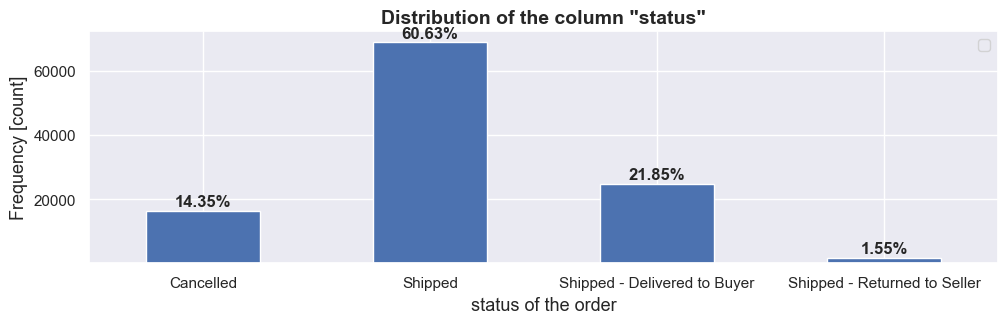

In [78]:
# Plot distribution of status
# Plot a figure to represent data of the above table(dataframe)
fig, ax = plt.subplots(figsize = (10,5))
status_proportion.plot(kind = "bar",y = "count",ax = ax)
plt.xlabel("status of the order", fontsize = 13)
#fit the x label and do not overlap with the xticks
plt.tight_layout()
plt.ylabel("Frequency [count]",fontsize = 13)
plt.yticks(ticks = range(20000,60001,20000))
plt.title('Distribution of the column "status"', fontsize = 14,fontweight = 550)
plt.xticks(rotation = "horizontal")
plt.legend("")
for x,y in enumerate(status_proportion["count"]):
    qty_value = status_proportion.index[x]
    plt.text(x,y+1500,status_proportion["Proportion(%)"].loc[qty_value],
            horizontalalignment = "center",fontweight = 700)
plt.show()

Observations:
Feature 'status' exhibits significant class imbalance, with the majority of orders being "Shipped" (60.63%). Classes such as "Cancelled" (14.35%) and various low-frequency statuses, including some related to shipping issues, highlight potential challenges for accurate prediction. The presence of specific status categories related to returns and deliveries suggests the need for tailored strategies in managing logistics, customer satisfaction, and order processing.

Feature Analysis on 'qty'

In [35]:
# create a pandas dataframe calculating the 
# porportion (and number of occurence) of the "qty" values

# calculate the respective "proportions" of values in "qty" 
# and store it in a pandas.Series
qty_proportion = round(amazonSaleRepDF["qty"].value_counts(normalize = True)*100,2)


In [36]:
#  rename series with "Proportion(%)", sort by index and change to dateframe
qty_proportion = qty_proportion.rename("Proportion(%)").sort_index().to_frame()
qty_proportion

,Proportion(%)
qty,
0,10.02
1,89.72
2,0.23
3,0.02
4,0.01
5,0.00
9,0.00
13,0.00
15,0.00


In [37]:
# add col "count"
qty_proportion["count"] = amazonSaleRepDF["qty"].value_counts().sort_index()
qty_proportion

,Proportion(%),count
qty,,
0,10.02,11376
1,89.72,101862
2,0.23,261
3,0.02,21
4,0.01,7
5,0.00,2
9,0.00,1
13,0.00,1
15,0.00,1


In [38]:
# change dtype of "Proportion(%)" column and concat string "%"
qty_proportion["Proportion(%)"] = (
    qty_proportion["Proportion(%)"].astype(str)
    .str.cat(np.full(fill_value = "%",shape = (len(qty_proportion),)))
)
qty_proportion

,Proportion(%),count
qty,,
0,10.02%,11376
1,89.72%,101862
2,0.23%,261
3,0.02%,21
4,0.01%,7
5,0.0%,2
9,0.0%,1
13,0.0%,1
15,0.0%,1


In [39]:
#keep only the rows with count > 2
qty_proportion = qty_proportion[qty_proportion["count"] > 1]
qty_proportion


,Proportion(%),count
qty,,
0,10.02%,11376
1,89.72%,101862
2,0.23%,261
3,0.02%,21
4,0.01%,7
5,0.0%,2


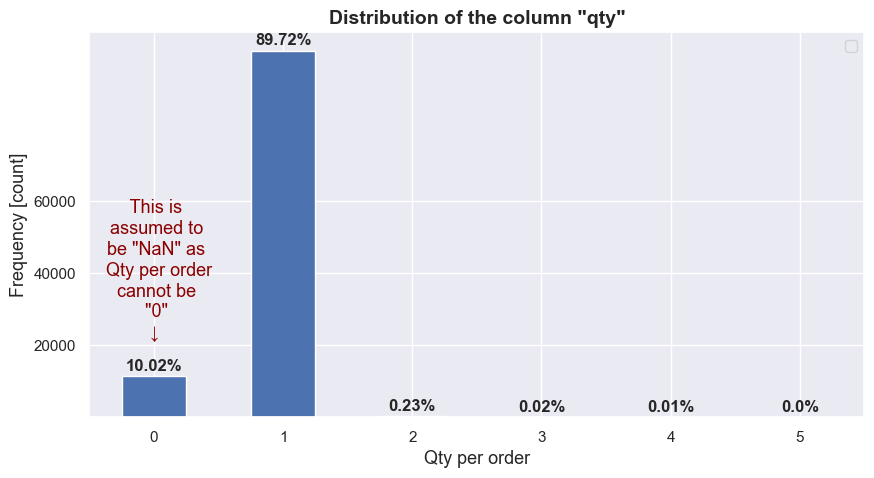

In [41]:
# Plot distribution of Quantity per order
# Plot a figure to represent data of the above table(dataframe)
fig, ax = plt.subplots(figsize = (10,5))
qty_proportion.plot(kind = "bar",y = "count",ax = ax)
plt.xlabel("Qty per order", fontsize = 13)
plt.ylabel("Frequency [count]",fontsize = 13)
plt.yticks(ticks = range(20000,60001,20000))
plt.title('Distribution of the column "qty"', fontsize = 14,fontweight = 550)
plt.xticks(rotation = "horizontal")
plt.legend("")
for x,y in enumerate(qty_proportion["count"]):
    qty_value = qty_proportion.index[x]
    plt.text(x,y+1500,qty_proportion["Proportion(%)"].loc[qty_value],
            horizontalalignment = "center",fontweight = 700)
        
plt.text(0,22000,' This is\n assumed to\n be "NaN" as\n  Qty per order\n  cannot be \n "0"\n↓',
         horizontalalignment = "center",color = "darkred", fontsize = 13)
plt.show()


Observations:

Feature "qty" is highly skewed (when assuming it as *continuous variable*), or
It's highly imbalanced (when assuming it as *categorical variable*)
It's logical to assume the value "0" as "NaN" (Null) because an order purchased cannot have quantity "0"
More than 99% of datapoints have value "1" or "NaN" so it may not add much information in the analysis.